In [1]:
# based on
# scaled up to full MNIST dataset
# https://github.com/SadmanSakib93/Federated-Learning-Keras/blob/main/Fed%20Learning%20-%20FL.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D
from keras import backend as K
from keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import os
import psutil
import csv
from itertools import repeat
from PIL import Image
from numpy import asarray

2023-02-05 22:14:17.171506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 22:14:17.171526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from keras.datasets import mnist
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

xTrain = xTrain.reshape(60000, 784)
xTest = xTest.reshape(10000, 784)
xTrain = xTrain.astype('float32')
x_test = xTest.astype('float32')
xTrain /= 255
x_test /= 255
print(xTrain.shape[0], 'train samples')
print(xTest.shape[0], 'test samples')

# convert class vectors to binary class matrices
yTrain = to_categorical(yTrain, 10)
yTest = to_categorical(yTest, 10)
yTrain.shape

60000 train samples
10000 test samples


(60000, 10)

In [4]:
# Global parameters

verb, epochs, batch_size = 0, 20, 64
numOfIterations = 25
numOfClients  = 5 # do not increase clients too much
modelLocation = "./Models/ANN_Sync_users_"+str(numOfClients)+str(numOfIterations)+"_FL_Model.h5"
accList, precList, recallList, f1List = [], [], [], []

In [5]:
# FOR TEST SPLIT
xServer, xClients, yServer, yClients = train_test_split(xTrain, yTrain, test_size=0.50,random_state=523) 
xServerTest, xClientsTest, yServerTest, yClientsTest = train_test_split(xTrain, yTrain, 
                                                                        test_size=0.50,random_state=523)

In [6]:
def createDeepModel():
   model = Sequential()
   model.add(Dense(8, activation='relu', input_shape=(784,)))
   model.add(Dense(16, activation='relu'))
#   model.add(Dense(64, activation='relu'))
   model.add(Dense(10, activation='softmax'))
   model.summary()
   model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),
              metrics=['accuracy'])
   return model

def predictTestData(yPredict, yTest):
    #Converting predictions to label
    print("yPredict",len(yPredict))
    pred = list()
    for i in range(len(yPredict)):
        pred.append(np.argmax(yPredict[i]))
    #Converting one hot encoded test label to label
    test = list()
    for i in range(len(yTest)):
        test.append(np.argmax(yTest[i]))
    return my_metrics(test, pred)

def sumOfWeights(weights):
    return sum(map(sum, weights))

def getWeights(model):
    allLayersWeights=deepModel.get_weights()
    return allLayersWeights

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    recall=recall_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, recall, f1Score

In [7]:
# Initially train central deep model
deepModel=createDeepModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 6,594
Trainable params: 6,594
Non-trainable params: 0
_________________________________________________________________


2023-02-05 22:14:19.102824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 22:14:19.103554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 22:14:19.103641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-05 22:14:19.103714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-05 22:14:19.106028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
def Analyze_training(h):
   f = plt.figure(figsize=(7, 3))
# summarize history for accuracy
# history.history.keys() -> dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
   plt.subplot(1,2,1)
   plt.plot(h.history['accuracy'])
   plt.plot(h.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
   plt.subplot(1,2,2)
   plt.plot(h.history['loss'])
   plt.plot(h.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
   return

In [9]:
deepModelAggWeights=[]
firstClientFlag=True

def updateServerModel(clientModel, clientModelWeight):
    global firstClientFlag
    for ind in range(len(clientModelWeight)):
        if(firstClientFlag==True):
            deepModelAggWeights.append(clientModelWeight[ind])            
        else:
            deepModelAggWeights[ind]=(deepModelAggWeights[ind]+clientModelWeight[ind])

def updateClientsModels():
    global clientsModelList
    global deepModel
    clientsModelList.clear()
    for clientID in range(numOfClients):
        m = keras.models.clone_model(deepModel)
        m.set_weights(deepModel.get_weights())
        clientsModelList.append(m)
    


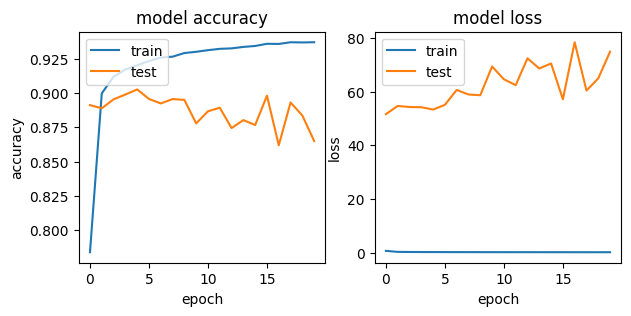

In [10]:
# baseline model non-federated
h = deepModel.fit(xTrain, yTrain,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verb,
                    validation_data=(xTest, yTest))
Analyze_training(h)

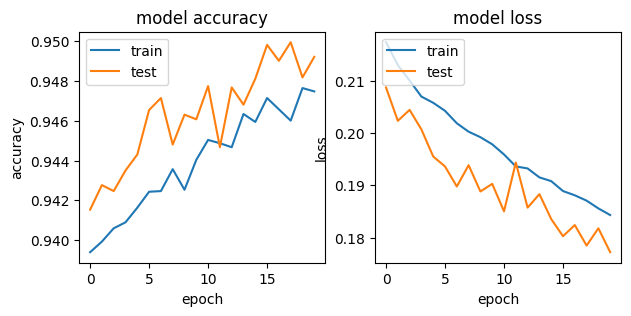

In [11]:
# 1. Train central model initially -----

def trainInServer():
    h = deepModel.fit(xServer, yServer, 
                      epochs=epochs, batch_size=batch_size, verbose=verb,
                      validation_data=(xServerTest, yServerTest))
    deepModel.save(modelLocation)
    Analyze_training(h)
trainInServer()

In [12]:
# ------- 2. Separate clients data into lists ----------
xClientsList=[]
yClientsList=[]
clientsModelList=[]
clientDataInterval=len(xClients)//numOfClients
lastLowerBound=0

for clientID in range(numOfClients):
    xClientsList.append(xClients[lastLowerBound : lastLowerBound+clientDataInterval])
    yClientsList.append(yClients[lastLowerBound : lastLowerBound+clientDataInterval])
    model=load_model(modelLocation)
    clientsModelList.append(model)
    lastLowerBound+=clientDataInterval
yClientsList[1].shape

(6000, 10)

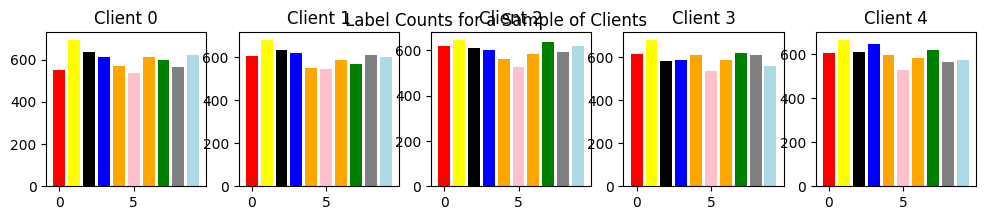

In [30]:
# Number of examples per layer for a sample of clients
import matplotlib.colors as mcolors

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'orange', 'green', 'grey', 'lightblue']


f = plt.figure(figsize=(12, 2))
f.suptitle('Label Counts for a Sample of Clients')
b = np.arange(0, 10, 1)
for i in range(numOfClients):
    client_dataset = yClientsList[i]
    bin = client_dataset[0]
    for k in range(1,len(client_dataset)):
       bin = bin + client_dataset[k]
    np.squeeze(bin).shape
    plt.subplot(int(numOfClients/5), 5, i+1)
    plt.title('Client {}'.format(i))
    plt.bar(b,bin[b], color = c)
        
       


In [14]:
# ------- 3. Update clients' model with intial server's deep-model ----------

#revisa si estas dos lineas valen
#for clientID in range(numOfClients):
#    clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, batch_size=batch_size, verbose=verbose)
        
start_time = time.time()
process = psutil.Process(os.getpid())
for iterationNo in range(1,numOfIterations+1):
    print("Iteration",iterationNo)
    for clientID in range(numOfClients):
        print("clientID",clientID)
        clientsModelList[clientID].compile(loss='mean_squared_error', optimizer='adam', 
                                          metrics=['accuracy'])
        
        history = clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, 
                                                 batch_size=batch_size, verbose=verb)
#        Analyze_training(history)
        clientWeight=clientsModelList[clientID].get_weights()
        # Find sum of all client's model
        updateServerModel(clientsModelList[clientID], clientWeight)
        firstClientFlag=False
        
    #Average all clients model
    
    for ind in range(len(deepModelAggWeights)):
        deepModelAggWeights[ind]/=numOfClients

    dw_last=deepModel.get_weights()

    for ind in range(len(deepModelAggWeights)): 
        dw_last[ind]=deepModelAggWeights[ind]
     
    #Update server's model
    deepModel.set_weights(dw_last) 
    print("Server's model updated")
    print("Saving model . . .")
    deepModel.save(modelLocation)
    # Servers model is updated, now it can be used again by the clients
    updateClientsModels()
    firstClientFlag=True
    deepModelAggWeights.clear()

    yPredict = deepModel.predict(xTest)
    acc, prec, recall, f1Score= predictTestData(yPredict, yTest)
    accList.append(acc)
    precList.append(prec)
    recallList.append(recall)
    f1List.append(f1Score)
    print("Acc:\n", acc)
    print("Prec:\n", prec)
    print("Recall:\n", recall)
    print("F1-Score:\n", f1Score)



Iteration 1
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9006
Precision : 0.913592141850474
Recall : 0.9006
f1Score : 0.9015218464810607
[[ 956    0    2    2    0    1   10    1    8    0]
 [   0 1008   31    9    0    0    3    7   77    0]
 [  16    1  948   11    3    0   14    5   34    0]
 [   0    0   15  940    0    3    0    9   42    1]
 [   4    1    7    1  899    0   11    5   28   26]
 [  22    0   10   81    4  604   19    7  143    2]
 [  23    1   10    0    6    1  887    0   30    0]
 [   7    4   23   15    2    1    0  951    9   16]
 [   4    1    5   12    3    2    6    5  934    2]
 [  11    6    0   13   22    1    0   11   66  879]]
Acc:
 0.9006
Prec:
 0.913592141850474
Recall:
 0.9006
F1-Score:
 0.9015218464810607
Iteration 2
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9013
Precision : 0.9141271178

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.8984
Precision : 0.9092959423728219
Recall : 0.8984
f1Score : 0.8991264000948513
[[955   0   3   4   0   1   8   2   7   0]
 [  0 997  51  10   0   0   1   9  67   0]
 [ 18   1 956   9   3   0   9   7  29   0]
 [  1   0  18 944   0   4   2   6  35   0]
 [  6   3  10   1 874   1   8   4  24  51]
 [ 20   0   6 102   5 631  12   7 107   2]
 [ 33   0  22   1   6   3 856   0  37   0]
 [  8   3  20  23   1   1   0 949   7  16]
 [  6   1   4  21   3   1   4   5 926   3]
 [  8   7   1  15  11   1   0  15  55 896]]
Acc:
 0.8984
Prec:
 0.9092959423728219
Recall:
 0.8984
F1-Score:
 0.8991264000948513
Iteration 12
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.8982
Precision : 0.9086714131057836
Recall : 0.8982
f1Score : 0.8988182901732098
[[956   0   3   3   0   1   8   2   7   0]
 [  0 997  54   9   0   0

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.8982
Precision : 0.9077127860106784
Recall : 0.8982
f1Score : 0.898935553951176
[[956   0   5   4   0   1   7   2   5   0]
 [  0 998  47  14   0   1   1  10  63   1]
 [ 17   2 951  15   2   1   7   8  29   0]
 [  1   0  13 952   0   4   2   7  31   0]
 [  5   4  11   3 877   1   6   4  22  49]
 [ 18   1   5  96   5 654  13   7  92   1]
 [ 36   0  30   2   8   3 838   0  41   0]
 [  8   3  17  22   3   2   0 951   5  17]
 [  5   2   4  33   4   2   3   7 911   3]
 [ 10   7   1  18  12   1   0  20  46 894]]
Acc:
 0.8982
Prec:
 0.9077127860106784
Recall:
 0.8982
F1-Score:
 0.898935553951176
Iteration 23
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.8973
Precision : 0.9066583258447972
Recall : 0.8973
f1Score : 0.8978675257918208
[[ 956    0    6    4    0    1    7    2    4    0]
 [   0 1000   44 

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.896
Precision : 0.9054518441297098
Recall : 0.896
f1Score : 0.8965912948642443
[[ 956    0    6    5    0    1    7    1    4    0]
 [   0 1001   47   23    0    1    1    8   53    1]
 [  15    1  953   18    3    0    8    9   24    1]
 [   1    0   11  958    0    5    2    7   25    1]
 [   6    4    9    3  872    0    5    8   21   54]
 [  18    1    4  116    5  646   12    6   83    1]
 [  36    0   31    2    6    3  835    0   45    0]
 [   8    2   18   29    3    2    0  941    6   19]
 [   5    4    4   34    6    3    4    7  904    3]
 [   9    7    1   20   12    2    0   20   44  894]]
Acc:
 0.896
Prec:
 0.9054518441297098
Recall:
 0.896
F1-Score:
 0.8965912948642443
Iteration 34
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.895
Precision : 0.9057556766410766
Recall : 0.895
f1S

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.8861
Precision : 0.898555422494755
Recall : 0.8861
f1Score : 0.8867099775956548
[[954   0   6   6   0   1   7   1   5   0]
 [  0 967  64  32   0   1   1  10  59   1]
 [ 12   1 948  23   3   0   8  11  25   1]
 [  1   0  12 962   0   3   2   6  23   1]
 [  5   3  10   2 872   0   5   9  20  56]
 [ 14   1   4 146   4 611  12   5  93   2]
 [ 36   0  33   2   9   4 816   0  58   0]
 [  7   2  20  31   3   2   0 935   6  22]
 [  5   3   4  38   5   3   3   8 902   3]
 [  7   7   1  20  12   2   0  21  45 894]]
Acc:
 0.8861
Prec:
 0.898555422494755
Recall:
 0.8861
F1-Score:
 0.8867099775956548
Iteration 45
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.8913
Precision : 0.9019097024843713
Recall : 0.8913
f1Score : 0.8919037175875126
[[955   0   6   4   0   1   7   1   6   0]
 [  0 981  55  23   0   1  

---Memory--- 5.93894952359845
--- 734.6284062862396 seconds (TRAINING)---


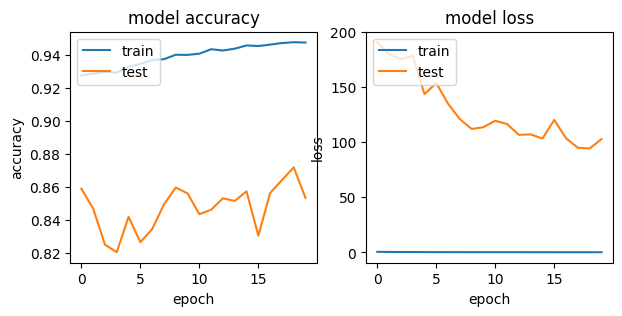

In [15]:
# 3. Evaluation at server

memoryTraining=process.memory_percent()
timeTraining=time.time() - start_time
print("---Memory---",memoryTraining)
print("--- %s seconds (TRAINING)---" % (timeTraining))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=verb, mode='auto')

history = deepModel.fit(xServer, yServer, epochs=epochs, 
                        validation_data = (xTest,yTest), verbose=verb)
                        # callbacks=[early_stopping])

learningAccs = history.history['val_accuracy']
learningLoss=history.history['val_loss']



Analyze_training(history)

In [16]:
# evaluation results
# resultSaveLocation=root_path+'Results/'+algoName+'_Users_vs_TR_vs_Iterations_vs_AccLossMemTime'+'.csv'
dfSave=pd.DataFrame(columns=['Clients', 'Iterations to converge', 'Accuracy', 'Loss', 'Memory', 'Time'])
dfSaveIndex=0
saveList = [numOfClients, len(learningLoss), learningAccs[len(learningAccs)-1], learningLoss[len(learningLoss)-1], memoryTraining, timeTraining]
dfSave.loc[dfSaveIndex] = saveList

yPredict = deepModel.predict(xTest)
acc, prec, recall, f1Score= predictTestData(yPredict, yTest)

print("Number of users:", numOfClients)
deepModel.save(modelLocation)


print("Iterations:", numOfIterations)
print("Memory:", memoryTraining)
print("Time:", timeTraining)
print(dfSave)

df_performance_timeRounds = pd.DataFrame(
    {'Accuracy': accList,
     'Precision': precList,
     'Recall': recallList,
     'F1-Score': f1List 
    })

yPredict 10000
Accuracy  : 0.8533
Precision : 0.8824646163923162
Recall : 0.8533
f1Score : 0.855265368982109
[[943   0   5   3   3   2  10   1  13   0]
 [  0 698  58 128   0   0   1   6 244   0]
 [ 14   0 914  19  10   1  12   6  56   0]
 [  1   1  15 936   0   8   0   8  41   0]
 [  7   2   7   6 902   0  13   4  24  17]
 [ 12   0   9  95   3 658  12   5  97   1]
 [ 32   0  20   0  12   6 849   2  37   0]
 [  4   2  22  35   9   2   0 926  10  18]
 [  3   0   3  16   3   7   5   2 934   1]
 [  9   7   0  20  46   6   0  16 132 773]]
Number of users: 5
Iterations: 50
Memory: 5.93894952359845
Time: 734.6284062862396
   Clients  Iterations to converge  Accuracy        Loss   Memory        Time
0      5.0                    20.0    0.8533  102.737808  5.93895  734.628406


In [17]:
import session_info
session_info.show()

In [18]:
#EOF